# Introduction to computational graphs for deep learning
This interactive notebook will present some of the basic concepts that state-of-the-art deep learning frameworks like PyTorch and Tensorflow are built upon. The reader is expected to have adequate theoretical and practical knowledge regarding multivariable calculus and probabilistic methods. Furthermore, after going through this notebook I am confident that the reader can implement a small-scale library themselfs, which implements the process of graph building and automatic calculation of the analytical gradient for a deep learning model!


### Background
*Feedforward* artificial neural networks (ANN) can be regarded as a collection of perceptrons (nodes) that each belong to  a respective layer that depend on some previous input to yield a response. A standard one-layer ANN usually performs the mapping $y = h(x)$ where $h(x) = Wx + b$ and $W$ are the learnable weights of each respective node $w_{ij}$ and $b$ is a learnable bias. A multi-layer ANN (MLP) on the other hand performs a multitude of these mappings, and can thus be formalized as $y = h_n(h_{n-1}(...(h_1(x)))$. Because of the depth of layers dependent on each other MLPs require the *backpropagation* algorithm to calculate the gradients of the weights $W$. Furthermore, if there are no non-linear activations between the layers of an MLP, it can always be summarized as a single-layer ANN. Therefore, an *activation function* has to be applied after the outputs of a layer. Two great historical alternatives are the sigmoid function $\sigma$ and the hypoerbolic tangent function $tanh$

>$\large \sigma(x) = \frac{1}{1 + e^{-x}}$<br>$\large tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

In modern day frameworks the backpropagation algorithm is implemented by means of computational graphs. These are formally defined as directed acyclic graphs (DAG) that directly follow the process from an input $x$ to output $y$ mapped by the model $f$. The DAG is precisely what it sounds like, a directed graph with no cycles. If there were cycles, then the backpropagation algorithm would never terminate as there would always be a next layer to calculate the gradient based on.


### Backpropagation
In a supervised learning context one can always measure some form of error or loss of the network after performing inference. 


### Constructing the DAG and performing the forward pass
The *forward pass* specifies walking through the DAG in the true direction of the graph, practically meaning, from input to output. Let's start with a simple example. We want to perform the affine transform $y = f(x)$ where $f(x) = Wx + b$. Visually, this can be represented by the DAG below


Here we denote the result of the operation $Wx$ as $g$, since we need a way to represent all intermediate step. Lets now assume that we are in a supervised learning context and we know the true value to $y$ which is $y'$ and we want to measure the loss $L$ by taking their difference according to $L = y' - y$. Then the entire DAG from input $x$ to final loss $L$ with all intermediate steps can be represented as


### Performing the backward pass in the DAG 
Lets assume we got a large loss, indicating that our prediction was incorrect and thus we want to update our weight $W$ and bias $b$ of the model. The steps of the *backward pass* is in accordance with the backpropagation algorithm, where the the gradient of the loss $L$ is calculated based on the paramater and multiplied with the previous layers nodes output. The first step thus becomes to calculate the gradient of the loss, with respect to the loss

>$\large \frac{\partial L}{\partial L} = 1$

which ofcourse is always equal to 1. The second step is to find the gradient of the operation that gave us the loss $L = y' - y$, and this yields the gradients

>$\large \frac{\partial L}{\partial y'} = 1$<br>$\large \frac{\partial L}{\partial y} = -1$

continuing with the backwards pass we come to the operation $y = g + b$. Here we can utilize the chain-rule to calculate the gradient of $g$ and $b$ respectively, since we already know the gradient of the loss with respect to $y$,

>$\large \frac{\partial L}{\partial g} = \frac{\partial L}{\partial y}*\frac{\partial y}{\partial g} = -1 * \frac{\partial y}{\partial g} = -1 * 1$<br>$\large \frac{\partial L}{\partial b} = \frac{\partial L}{\partial y}*\frac{\partial y}{\partial b} = -1*\frac{\partial y}{\partial b} = -1 * 1$

Already at this point we can see the beauty and simplicity of the DAG in a backpropagation scenario. Instead of working with all neurons of a layer directly, they are summarized as a parameter and their operation on the input is represented as a node in the DAG. It becomes intuitive to watch the gradient flowing backwards through the model, utilizing the chain-rule to analytically calculate the gradients of each node in a sequential manner. Anyway, lets continue with our backwards pass. Now that we know the gradient of the loss $L$ with respect to $g$, we can find the gradient of the weight parameter $W$ for our model. Similarly as in the previous steps, utilizing the chain-rule, this becomes

>$\large \frac{\partial L}{\partial W} = \frac{\partial L}{\partial y}*\frac{\partial y}{\partial g}*\frac{\partial g}{\partial W} = -1 * 1 * \frac{\partial g}{\partial W} = -1 * 1 * x$<br>$\large \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y}*\frac{\partial y}{\partial g}*\frac{\partial g}{\partial x} = -1 * 1 * \frac{\partial g}{\partial x} = -1 * 1 * W$

and we have analytically found the two gradients that we require to update our model parameters $W$ and $b$ such that our next prediction would yield a smaller loss! Even though we calculate gradients of the loss with respect to all variables involved in the DAG it is not always the case that we want to, or even should, update them. For example, in this backward pass process we accumulate gradients for both $x$ and $y'$, but these are constant data that we are trying to map with our model parameters. Thus, we do **not** want to update their initial values based on their respective gradients. So when implementing the DAG and backward pass, pay close attention to what variables you are applying the gradient to...

The DAG with respective gradients in green can be seen below (in case the math wasn't very informative...)



This is pretty much all the theory you need to implement your own autograd library! Below is an extremely barebones implementation of a single-layer feedforward ANN that is trained to predict the values of a vector. This is performed by means of minizing the mean squared error and applying gradient updates with stochastic gradient descent (SGD). 

In [34]:
"""
The tensor class we are building for the DAG construction holds a data attribute which are of type np.ndarray,
apart from that, no other libraries are requires. Partialfunction is used to freeze the ops classes after being
used on some data, such that the tensors of interest can be saved and used for analytical gradient computation.
"""
import numpy as np
import matplotlib.pyplot as plt
from functools import partialmethod

In [35]:
class Tensor(object):
    def __init__(self, data, requires_grad=True):
        self.requires_grad = requires_grad
        self.grad = None
        self._ctx = None
        
        if isinstance(data, list):
            data = np.array(data, dtype=np.float32)
        elif isinstance(data, np.float32):
            data = np.array(data, dtype=np.float32)
        
        self.data = data
    
    def __repr__(self):
        return f'<tensor.Tensor {self.data}, grad={self.grad}, _ctx={self._ctx}>'
    
    def backward(self, allow_fill=True):
        if self._ctx is None:
            return
        
        if self.grad is None and allow_fill:
            self.grad = np.ones_like(self.data)
        
        gradients = self._ctx.backward(self._ctx, self.grad)
        gradients = [gradients] if len(self._ctx.parents) == 1 else gradients
        for tensor, gradient in zip(self._ctx.parents, gradients):
            if gradient is None:
                continue
                
            tensor.grad = gradient
            tensor.backward(allow_fill=False)
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
    
    @classmethod
    def uniform(cls, *shape, **kwargs):
        return cls(np.random.uniform(-1., 1., size=shape)
                   / np.sqrt(np.prod(shape)).astype(np.float32), **kwargs)
    
    def mean(self):
        div = Tensor(np.array([1 / self.data.size], dtype=self.data.dtype))
        return self.sum().mul(div)


In [36]:
class Function(object):
    def __init__(self, *tensors):
        self.parents = tensors
        self.saved_tensors = []
        self.requires_grad = any([tensor.requires_grad for tensor in tensors])
    
    def save_for_backward(self, *x):
        self.saved_tensors.extend(x)
    
    def apply(self, arg, *x):
        ctx = arg(self, *x)
        output = Tensor(arg.forward(ctx, self.data, *[tensor.data for tensor in x]))
        output._ctx = ctx
        return output


class Add(Function):
    @staticmethod
    def forward(self, x, y):
        return x + y
    
    @staticmethod
    def backward(self, grad_out):
        return grad_out, grad_out


class Mul(Function):
    @staticmethod
    def forward(self, x, y):
        self.save_for_backward(x, y)
        return x * y
    
    @staticmethod
    def backward(self, grad_out):
        x, y = self.saved_tensors
        return y * grad_out, x * grad_out


class Sub(Function):
    @staticmethod
    def forward(self, x, y):
        return x - y
    
    @staticmethod
    def backward(self, grad_out):
        return grad_out, -grad_out

    
class Sum(Function):
    @staticmethod
    def forward(self, x):
        self.save_for_backward(x)
        return np.array([x.sum()])
    
    @staticmethod
    def backward(self, grad_out):
        x, = self.saved_tensors
        return grad_out * np.ones_like(x)

__allops__ = {
    'add': Add,
    'mul': Mul,
    'sub': Sub,
    'sum': Sum
}


def register_all():
    for name, func in __allops__.items():
        setattr(Tensor, name, partialmethod(func.apply, func))

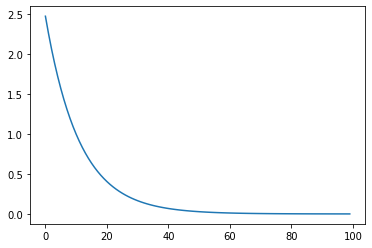

In [44]:
np.random.seed(98)
register_all()

history = []
learning_rate = 0.1
x = Tensor([.5, .1, -.7], requires_grad=False)
W = Tensor.uniform(3)
b = Tensor([1.])
y_true = Tensor([-1., .7, -.5], requires_grad=False)

# Perform a couple of forward pass specified by the DAG
# and perform SGD optimizer update on W and b
for _ in range(100):
    # get output prediction y
    g = x.mul(W)
    y = g.add(b)
    # calculate MSE
    error = y_true.sub(y)
    loss = error.mul(error).mean()
    loss.backward()
    history.append(loss.data)

    W.data = W.data - learning_rate * W.grad
    b.data = b.data - learning_rate * b.grad

plt.plot(history) 
!